## ..

In [2]:
#from sklearn import linear_model
from torch import nn
from numpy.random import randint

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import torch  as tc

class SineActivation(nn.Module):
    def __init__(self): 
        super(SineActivation, self).__init__() 
    def forward(self, x):
        return tc.sin(x)
    
class Regressao_M(nn.Module):
    def __init__(self, neuronio, M, output=1, activation=nn.Mish(), creat_p=False, N_of_paramater=1):
        super().__init__()
        self.neuronio = neuronio
        self.M = M
        self.output = output
        self.creat_p = creat_p
        self.N_of_paramater = N_of_paramater

        # Lista para armazenar as camadas lineares
        self.hidden_layers = nn.ModuleList([nn.Linear(1, neuronio)])
        self.hidden_layers.extend([nn.Linear(neuronio, neuronio) for _ in range(M-1)])
        
        # Última camada linear
        self.output_layer = nn.Linear(neuronio, output)

        # Função de ativação
        self.activation = activation

        if creat_p:
            #self.acceleration = nn.Parameter(tc.rand(N_of_paramater))
            self.acceleration = nn.Parameter(tc.ones(N_of_paramater)*2)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x

#generation of data
def numerical_solution2(N,G0,c1,c2,c3,c4,tau,w,V0):
    def f(t,q,V):
        r=-q/tau+c1*V+c2*V**2+c3*V**3+c4*V**4
        return r
    def v(t,w):
        return V0*np.cos(w*t)
    Nc = 4
    dt = 2*np.pi/(N)/w

    n  = np.zeros(N)
    I  = np.zeros(N)
    V  = np.zeros(N)
    t  = np.zeros(N)
    n[0] = 6
    I[0] = 1
    t[0] = 0
    V[0] = v(t[0],w)
    for j in range(Nc):
        if j>1:
            n[0]=n[-1]
            I[0]=I[-1]
        for i in range(N-1):
        #RK4
            t[i+1]=t[i]+dt
            k1=dt*f(t[i],n[i],v(t[i],w));
            k2=dt*f(t[i]+dt/2,n[i]+k1/2,v(t[i]+dt/2,w));
            k3=dt*f(t[i]+dt/2,n[i]+k2/2,v(t[i]+dt/2,w));
            k4=dt*f(t[i]+dt,n[i]+k3,v(t[i]+dt,w));
            n[i+1]=n[i]+(1.0/6.0)*(k1+k4+2.0*(k2+k3))
            I[i+1]=(G0+n[i+1])*v(t[i+1],w)
            V[i+1]=v(t[i+1],w)
    return t,I,V,n



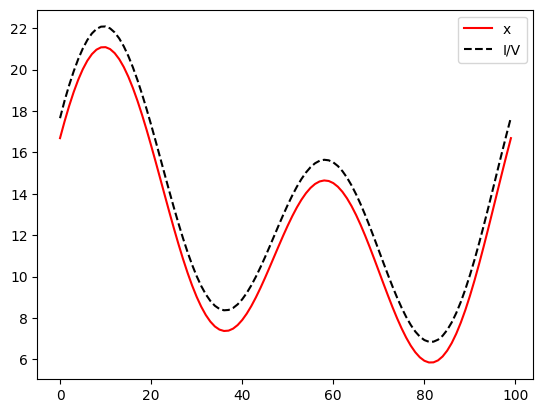

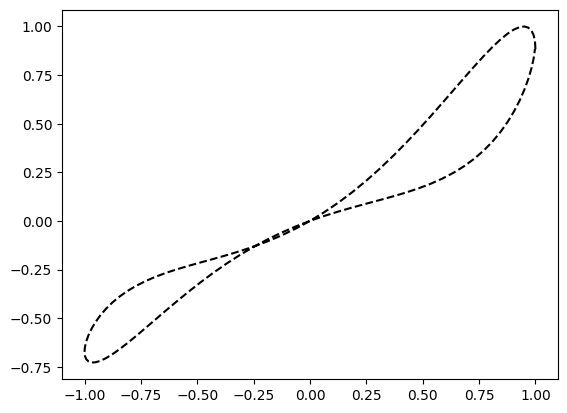

In [3]:
N=100;G0=1;c1=1.0;c2=1;c3=0;c4=0;tau=1;w=1;V0=5;
time,current,potential,dn = numerical_solution2(N,G0,c1,c2,c3,c4,tau,w,V0)
   
plt.plot(dn,"r",label="x")
plt.plot(current/potential,"k--",label="I/V")
plt.legend()
plt.show()
plt.plot(potential/potential.max(),current/current.max(),"k--")
plt.show()

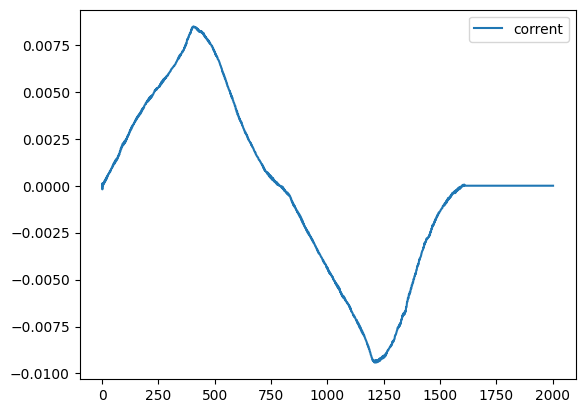

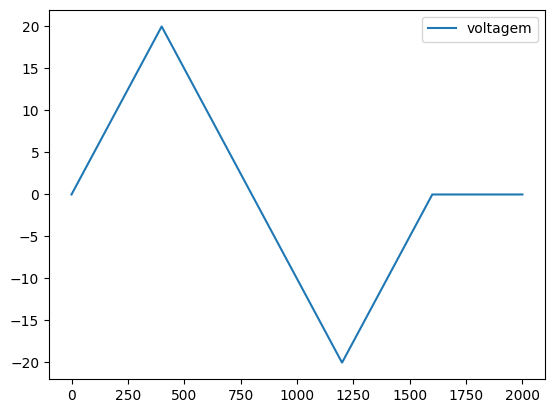

C:\Users\gubio\AppData\Local\Temp\ipykernel_13964\1261287875.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.plot(corrente/voltagem,"k-",label="I/V");


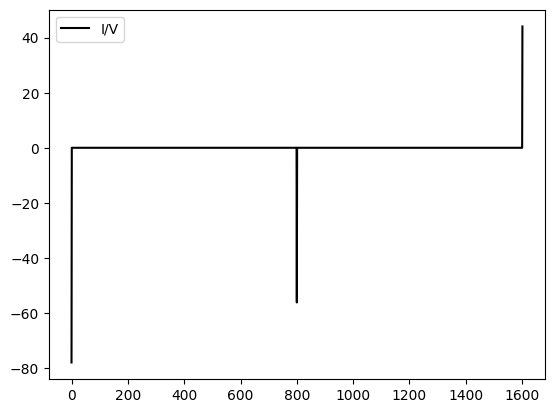

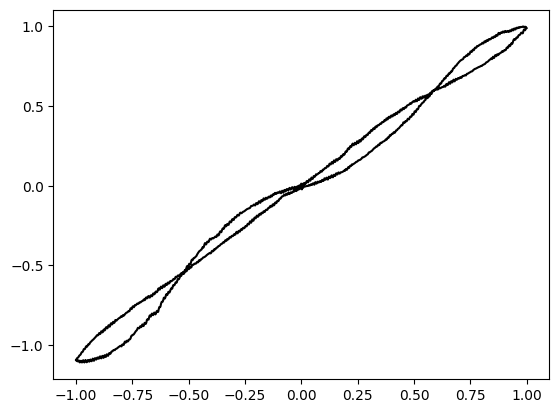

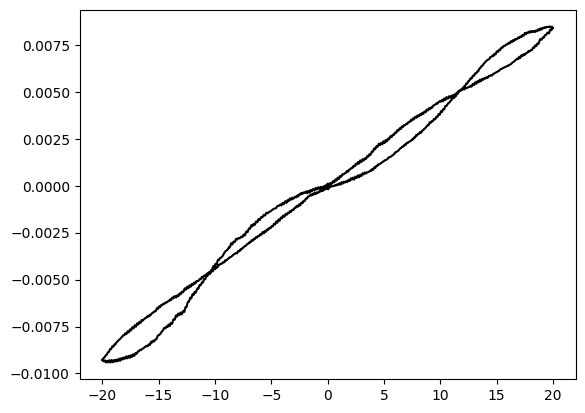

In [33]:
# Carregar dados do arquivo TXT
# O 'delimiter' é definido como '\t' para tabulação, e 'dtype' como float para converter os números corretamente
dataset = np.loadtxt('Book1_period_900s.txt', delimiter='\t', dtype=float)
voltagem, corrente = dataset[:,0],dataset[:,1]
plt.plot(corrente,"-",label="corrent");
plt.legend()
plt.show()
plt.plot(voltagem,"-",label="voltagem");
plt.legend()
plt.show()
plt.plot(corrente/voltagem,"k-",label="I/V");
plt.legend()
plt.show()
plt.plot(voltagem/voltagem.max(),corrente/corrente.max(),"k-"); plt.show()
plt.plot(voltagem,corrente,"k-"); plt.show()

### EDO solution

In [ ]:
def traino(lr_,neuronio_,camadas,fun_activation,epochs=1000,N=100):
    # Criando os dados de treino
    time = np.linspace(0,2*np.pi)
    dataset = np.loadtxt('Book1_period_900s.txt', delimiter='\t', dtype=float)
    d_potencial, corrent = dataset[:,0],dataset[:,1]


    corrent,d_potencial = corrent/corrent.max(),d_potencial/d_potencial.max()
    t_train = tc.tensor(time,requires_grad=True,dtype=tc.float).reshape(-1,1)
    I_data  = tc.tensor(corrent,dtype=tc.float).reshape(-1,1)
    V_data  = tc.tensor(d_potencial,dtype=tc.float).reshape(-1,1)

    # criando o modelo

    model = Regressao_M(neuronio = neuronio_,M=camadas,output=1,activation=fun_activation,creat_p = True,N_of_paramater = 3)
    opt = tc.optim.Adam(params=model.parameters(),lr=lr_,betas=(0.9,0.999))
    lr_step = tc.optim.lr_scheduler.StepLR(opt, step_size=500, gamma=0.9)
    LOSS = []
    
    for _ in range(epochs):
        model.train()
        x_preds = model(t_train)
        #a_,b_,C_1,C_2 = model.acceleration
        G0,C_1,C_2 = model.acceleration
        ###########################################################################
        # Derivando
        dx_dt = tc.autograd.grad(x_preds,t_train, grad_outputs=tc.ones_like(x_preds), create_graph=True,retain_graph=True)[0]
        # Edo
        loss_ode_dydt = tc.mean( abs(dx_dt + x_preds -C_1*V_data - C_2*(V_data)**2) ) # d
        # Usando os dado experimentais
        loss_data = tc.mean(abs(I_data/V_data - G0 + x_preds) )
        
        loss = loss_ode_dydt + loss_data 
        ############################################################################
        LOSS.append(loss.detach().numpy())
        opt.zero_grad()
        loss.backward(retain_graph=True)
        opt.step()
        lr_step.step()
    
    plt.plot(x_preds.detach().numpy(),"k.-")
    plt.plot((I_data/V_data).detach().numpy(),"r--")
    plt.show()
    # Primeiro subplot
    
    plt.plot(LOSS,label="Treino")
    plt.legend()
    plt.yscale('log')
    plt.show()
    # Segundo subplot a_,b_,C_1,C_2 = model.acceleration

    G0,C_1,C_2 = model.acceleration.detach().numpy()
    time,corrent,d_potencial,x_true = numerical_solution2(N,G0,C_1,C_2,c3,c4,tau,w,V0)
    corrent,d_potencial = corrent/corrent.max(),d_potencial/d_potencial.max()
    plt.plot(d_potencial,corrent,"r-",label='Predict')
    plt.plot(V_data,I_data,"k--",label='Data')

    plt.ylabel('I(t)')
    plt.xlabel('V(t)')
    plt.grid(True)
    plt.legend()
    plt.show()
    print(f"lr:{lr_} neuronio_ {neuronio_} camadas {camadas} fun_activation{fun_activation} ")
    print(f" Parametros : a = {G0}, C_1 ={C_1*2}, C_2 = {C_2} |")

In [ ]:
traino(lr_=0.01,neuronio_=10,camadas=5,fun_activation=SineActivation(),epochs=5000,G0=1,c1=1.0,c2=1,c3=0,c4=0,tau=1,w=1,V0=100)